# News Aggregator and Recommender

In [40]:
import random
import os
import json
import ast
from datetime import datetime, timezone

import feedparser
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [41]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

### Data Collection

First, we will read in multiple RSS feeds from media outlets (with which we have a subscription). Here, we do it for *The Wall Street Journal*, *The New York Times*, and *Financial Times*. We will store their information in a dictionary, saving metadata from each article, including title, description, categories, and date.

In [3]:
# Define the RSS feeds
feeds = {
    'WSJ_Opinion': 'https://feeds.a.dj.com/rss/RSSOpinion.xml',
    'WSJ_WorldNews': 'https://feeds.a.dj.com/rss/RSSWorldNews.xml',
    'WSJ_USBussiness': 'https://feeds.a.dj.com/rss/WSJcomUSBusiness.xml',
    'WSJ_MarketsMain': 'https://feeds.a.dj.com/rss/RSSMarketsMain.xml',
    'WSJ_Tech': 'https://feeds.a.dj.com/rss/RSSWSJD.xml',
    'WSJ_Lifestyle': 'https://feeds.a.dj.com/rss/RSSLifestyle.xml',
    'NYT_World': 'https://rss.nytimes.com/services/xml/rss/nyt/World.xml',
    'NYT_US': 'https://rss.nytimes.com/services/xml/rss/nyt/US.xml',
    'NYT_Politics': 'https://rss.nytimes.com/services/xml/rss/nyt/Politics.xml',
    'NYT_Business': 'https://rss.nytimes.com/services/xml/rss/nyt/Business.xml',
    'NYT_Economy': 'https://rss.nytimes.com/services/xml/rss/nyt/Economy.xml',
    'NYT_EnergyEnvironment': 'https://rss.nytimes.com/services/xml/rss/nyt/EnergyEnvironment.xml',
    'NYT_Tech': 'https://rss.nytimes.com/services/xml/rss/nyt/Technology.xml',
    'NYT_PersonalTech': 'https://rss.nytimes.com/services/xml/rss/nyt/PersonalTech.xml',
    'NYT_Sports': 'https://rss.nytimes.com/services/xml/rss/nyt/Sports.xml',
    'NYT_Science': 'https://rss.nytimes.com/services/xml/rss/nyt/Science.xml',
    'NYT_Space': 'https://rss.nytimes.com/services/xml/rss/nyt/Space.xml',
    'NYT_BooksReview': 'https://rss.nytimes.com/services/xml/rss/nyt/Books/Review.xml',
    'NYT_Movies': 'https://rss.nytimes.com/services/xml/rss/nyt/Movies.xml',
    'FT': 'https://www.ft.com/myft/following/1e8ea6d7-389e-4fbe-89e1-e0dd4426afee.rss'
}

In [4]:
# Function to parse RSS feed
def parse_rss(feed_url, feed_name, is_ft=False, is_wsj=False):
    feed = feedparser.parse(feed_url)
    articles = []
    for entry in feed.entries:
        # Extract the title and description
        title = entry.title
        description = entry.description
        # Strip HTML tags for FT descriptions
        if is_ft:
            soup = BeautifulSoup(description, 'html.parser')
            for tag in soup(['a', 'img', 'br']):
                tag.decompose()
            description = soup.get_text(separator=" ").strip().rstrip(' ,')

        # Extract the publication date
        date = None
        if 'published' in entry:
            date = entry.published
        elif 'published_parsed' in entry:
            date = datetime(*entry.published_parsed[:6]).isoformat()
        if date:
            date = date.replace('GMT', '+0000')

        # Extract the number of days since published
        if date:
            article_date = datetime.strptime(date, '%a, %d %b %Y %H:%M:%S %z')
            now = datetime.now(article_date.tzinfo)
            days_old = (now - article_date).days
        else:
            days_old = np.nan

        # Extract categories
        categories = []
        if 'tags' in entry:
            for tag in entry.tags:
                if is_wsj and tag.get('term') == 'PAID':
                    continue
                categories.append(tag.get('term').lower())

        # Add all info to the article
        link = entry.link
        articles.append({
            'title': title,
            'description': description,
            'categories': categories,
            'date': date,
            'link': link,
            'feed_name': feed_name,
            'source': feed_name.split('_')[0],
            'days_old': days_old
        })
    return articles

In [5]:
# Collect articles from all feeds into a list of dictionaries
all_articles_list = []
for feed_name, feed_url in feeds.items():
    is_ft = 'FT' in feed_name
    is_wsj = 'WSJ' in feed_name
    articles = parse_rss(feed_url, feed_name, is_ft=is_ft, is_wsj=is_wsj)
    all_articles_list.extend(articles)

# Convert the list of dictionaries to a DataFrame
new_articles_df = pd.DataFrame(all_articles_list)

In [6]:
new_articles_df.head()

,title,description,categories,date,link,feed_name,source,days_old
0,"Hamas Executes Six Hostages, Including an American","It murders them in Rafah, where Biden and Harris delayed Israel’s entry with threats and by withholding weapons.",[],"Sun, 01 Sep 2024 14:26:00 -0400",https://www.wsj.com/articles/hamas-executes-six-hostages-including-an-american-gaza-war-rafah-4907e7c6,WSJ_Opinion,WSJ,0
1,"Biden-Harris Undercut Aukus, Their One Foreign-Policy Success",The administration is defying Congress and jeopardizing a key part of the security pact.,[],"Fri, 30 Aug 2024 16:45:00 -0400",https://www.wsj.com/articles/biden-harris-undercut-their-one-foreign-policy-success-pillar-ii-44dde039,WSJ_Opinion,WSJ,2
2,Judges Say You Can't Build That,Two case studies in why the U.S. desperately needs permitting reform.,[],"Sun, 01 Sep 2024 14:21:00 -0400",https://www.wsj.com/articles/court-rulings-oil-and-gas-permits-deborah-boardman-climate-ferc-26247bb1,WSJ_Opinion,WSJ,0
3,"Workers of the World, Vote!",So Big Labor will say. But most private-sector union members have never cast a ballot for their own union.,[],"Fri, 30 Aug 2024 16:48:00 -0400",https://www.wsj.com/articles/workers-of-the-world-vote-unions-voting-election-36f9087a,WSJ_Opinion,WSJ,2
4,Judicial Ethics and Double Standards,Calling Dick Durbin: The Climate Judiciary Project is trying to influence judges.,[],"Fri, 30 Aug 2024 17:38:00 -0400",https://www.wsj.com/articles/climate-judiciary-project-judges-environmental-law-institute-supreme-court-dick-durbin-sheldon-whitehouse-5256997a,WSJ_Opinion,WSJ,1


In [4]:
# Merge the current articles into the aggregate list
def update_articles_archive(archive_df, current_df):
    # Create a unique identifier based on the title and link
    archive_df['identifier'] = archive_df.apply(lambda row: (row['title'], row['link']), axis=1)
    current_df['identifier'] = current_df.apply(lambda row: (row['title'], row['link']), axis=1)

    # Create a dictionary from the existing articles to preserve labels
    existing_articles = archive_df.set_index('identifier').to_dict(orient='index')

    updated_articles = []
    for _, row in current_df.iterrows():
        identifier = row['identifier']
        if (identifier in existing_articles) and ('label' in existing_articles[identifier]):
            row['label'] = existing_articles[identifier]['label']
        updated_articles.append(row)

    updated_articles_df = pd.DataFrame(updated_articles)
    combined_df = pd.concat([archive_df, updated_articles_df]).drop_duplicates(subset='identifier', keep='last')
    combined_df = combined_df.drop(columns=['identifier'])

    return combined_df

In [44]:
archive_df = pd.read_csv('archive/articles_all_09_01_24.csv')
articles_df = update_articles_archive(archive_df, new_articles_df)

,title,description,categories,date,link,feed_name,source,days_old,predicted_category,predicted_probs,label
402,Our Bigger Brains Came With a Downside: Faster Aging,A study comparing chimpanzee and human brains suggests that the regions that grew the most during human evolution are the most susceptible to aging.,"['your-feed-science', 'research', 'brain', 'animal behavior', 'age, chronological', 'monkeys and apes', 'evolution (biology)']","Wed, 28 Aug 2024 19:40:28 +0000",https://www.nytimes.com/2024/08/28/science/chimpanzee-brain-aging.html,NYT_Science,NYT,4,Sci/Tech,"[0.0009682467207312584, 6.42530940240249e-05, 0.0044743274338543415, 0.9944932460784912]",1.0
195,The Venezuelan City Devastated By Migration,"About a quarter of the residents of Maracaibo, Venezuela’s second-largest city, have moved away — and more are expected to soon follow.","['maracaibo (venezuela)', 'population', 'immigration and emigration', 'venezuela', 'politics and government', 'economic conditions and trends', 'shortages', 'embargoes and sanctions', 'labor and jobs', 'maduro, nicolas', 'gonzalez, edmundo (1949- )', 'machado, maria corina']","Sun, 01 Sep 2024 21:37:23 +0000",https://www.nytimes.com/2024/09/01/world/americas/venezuela-maracaibo-migration.html,NYT_World,NYT,0,World,"[0.9984588623046875, 0.0004959744401276112, 0.000630370166618377, 0.0004147967556491494]",NaN
139,Auto Industry's EV Retreat Hastens,Ford’s move to delay certain projects follows rivals and comes as automakers face pressure from regulators and China.,[],"Thu, 22 Aug 2024 05:30:00 -0400",https://www.wsj.com/articles/auto-industrys-ev-retreat-hastens-94466271?mod=pls_whats_news_us_business_f,WSJ_USBussiness,WSJ,10,Business,"[0.0025473914574831724, 0.00010562581883277744, 0.9960533380508423, 0.0012937096180394292]",1.0


In addition to the data that we can pull directly from the RSS feeds, we can also use NLP to predict our own class label for each article. We will use a [BERT model](https://huggingface.co/fabriceyhc/bert-base-uncased-ag_news) from Hugging Face, fine-tuned on the [ag_news](https://huggingface.co/datasets/fancyzhx/ag_news?row=4) dataset. This takes in text associated with an article (e.g., a title and description) and outputs one of 4 class labels: "World", "Sports", "Business", and "Sci/Tech". These class labels will then be added to the articles data and used to make recommendations.

In [10]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("fabriceyhc/bert-base-uncased-ag_news")
model = AutoModelForSequenceClassification.from_pretrained("fabriceyhc/bert-base-uncased-ag_news")

/Users/jakepappo/micromamba/envs/sauron/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/jakepappo/micromamba/envs/sauron/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
categories = ["World", "Sports", "Business", "Sci/Tech"]

# Functions to classify title+description using the fine-tuned BERT model
def classify_article(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return categories[predicted_class], probabilities[0].tolist()

def classify_row(row):
    # If the predictions have already been calculated, return them
    if pd.notna(row.get('predicted_category')) and pd.notna(row.get('predicted_probs')):
        return pd.Series([row['predicted_category'], row['predicted_probs']])
    # If not, make the predictions and store them
    text = f"{row['title']} - {row['description']}"
    predicted_category, probabilities = classify_article(text)
    return pd.Series([predicted_category, probabilities])

In [12]:
articles_df[['predicted_category', 'predicted_probs']] = articles_df.apply(classify_row, axis=1)

Let's take a look at 5 random articles to see how the BERT-predicted categories do. In general, the model perform wells, reflecting its 93.75% validation accuracy on the [ag_news](https://huggingface.co/datasets/fancyzhx/ag_news?row=4) dataset. However, many articles often transcend category lines (e.g., macroeconomic news relates to both `Business` and `World`). Still, this will allow our recommender to make high-level distinctions between different articles. It is also especially helpful for assigning categories to WSJ's articles, from which we could not extract `categories` from the RSS feed.

In [13]:
articles_df.sample(n=5)[['title', 'description', 'categories', 'predicted_category', 'predicted_probs']]

,title,description,categories,predicted_category,predicted_probs
153,Don't Wait for the Next Big Data Breach to Freeze Your Credit,Freezing your credit is a simple and free protection from identity thieves with few downsides.,[],Business,"[0.0012268217978999019, 0.00013605624553747475, 0.9651965498924255, 0.03344056010246277]"
69,What Barcelona’s Tourism Protests Mean for Its Biggest Soccer Club,Demonstrators have sprayed visitors with water pistols. F.C. Barcelona is watching with interest.,[],World,"[0.9137588739395142, 0.08099153637886047, 0.0026812218129634857, 0.002568356692790985]"
453,How Dinosaurs Rocked Victorian Society,"In “Dinosaurs at the Dinner Party,” the science writer Edward Dolnick takes on the 19th-century discovery of dinosaur fossils: “What was it like to try to grapple with an idea that hadn’t occurred to anybody?”","['books and literature', 'paleontology', 'dinosaurs', 'victorian era', 'collectors and collections', 'content type: personal profile', 'dolnick, edward', 'dinosaurs at the dinner party: how an eccentric group of victorians discovered prehistoric creatures and accidentally upended the world (book)', 'england']",Sci/Tech,"[0.0008363869274035096, 7.58348687668331e-05, 0.006050622556358576, 0.9930371642112732]"
70,"Book Review: ‘Christopher Isherwood Inside Out,’ by Katherine Bucknell","Though it downplays unflattering details, Katherine Bucknell’s big biography hails the 20th-century writer as an early advocate for the “chosen family.”","['books and literature', 'writing and writers', 'content type: personal profile', 'homosexuality and bisexuality', 'bachardy, don', 'isherwood, christopher', 'christopher isherwood inside out (book)', 'bucknell, katherine']",Sci/Tech,"[0.13494527339935303, 0.005111499689519405, 0.011170207522809505, 0.8487730026245117]"
277,Labor Day Travel Plans? What to Know About the Hotel Strike.,"Though hotel chains say they’ll continue to operate normally, travelers could see disruptions as employees walked off the job in cities from Boston to Honolulu. Here’s what to know.","['travel and vacations', 'strikes', 'content type: service', 'hilton worldwide holdings inc', 'hyatt hotels corp', 'marriott international inc', 'unite here']",Business,"[0.0007884988444857299, 8.27574694994837e-05, 0.9984171390533447, 0.0007115735788829625]"


Some articles may  appear in different RSS feeds of the same news source (e.g., `NYT_US` and `NYT_Politics`), so we will ensure `all_articles` is a unique set.

In [26]:
def drop_duplicate_articles(articles_df, verbose=False):
    # Drop duplicate articles based on a unique identifier of the title and link
    articles_df['identifier'] = articles_df.apply(lambda row: (row['title'], row['link']), axis=1)
    unique_articles_df = articles_df.drop_duplicates(subset='identifier', keep='first')
    unique_articles_df = unique_articles_df.drop(columns=['identifier'])
    articles_df = unique_articles_df
    if verbose:
        duplicate_count = len(articles_df) - len(unique_articles_df)
        print("Number of duplicate articles:", duplicate_count)

    return articles_df

In [27]:
articles_df = drop_duplicate_articles(articles_df)

Now I will label the articles with a binary variable `label` that indicates if I would read it. Our recommender model can then learn my preferences and display articles with a predicted `label=1`.

In [15]:
def label_article(title, description):
    print("\nTitle:", title)
    print("Description:", description)
    while True:
        label = input("Enter label (1 or 0): ")
        if label in {'1', '0'}:
            return int(label)
        else:
            print("Invalid input. Please enter 1 or 0.")

def label_articles(df):
    for index, row in df.iterrows():
        if pd.isna(row['label']):
            df.at[index, 'label'] = label_article(row['title'], row['description'])
    return df

In [21]:
articles_df = label_articles(articles_df)

Now we want to save all the articles into an updated archive such that we do not lose their information once the RSS feeds update.

In [42]:
today_date_str = datetime.now().strftime('%m_%d_%y')
updated_archive_filepath = f'articles_all_{today_date_str}.csv'
articles_df.to_csv(updated_archive_filepath, index=False)

### Data Exploration

<Axes: xlabel='label'>

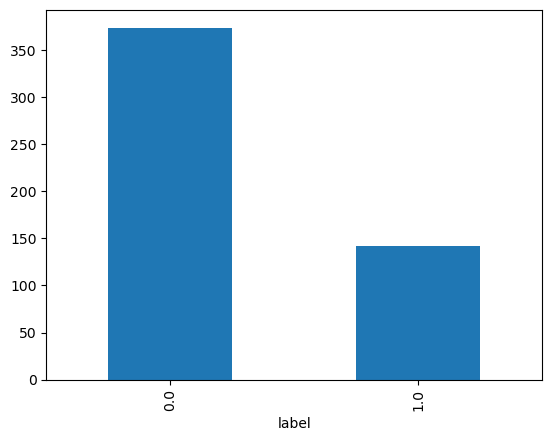

In [22]:
articles_df['label'].value_counts().plot(kind='bar')

In [18]:
def compare_variable(variable, normalize=True):
    # Prepare the data for plotting
    overall_counts = articles_df[variable].value_counts(normalize=normalize).sort_index()
    labeled_counts = articles_df[articles_df['label'] == 1][variable].value_counts(normalize=normalize).sort_index()

    # Convert to DataFrames for Seaborn
    overall_df = overall_counts.reset_index()
    overall_df.columns = [variable, 'Proportion']
    overall_df['Articles'] = 'All'

    labeled_df = labeled_counts.reset_index()
    labeled_df.columns = [variable, 'Proportion']
    labeled_df['Articles'] = 'Preferred'

    combined_df = pd.concat([overall_df, labeled_df])

    # Create the plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=variable, y='Proportion', hue='Articles', data=combined_df, palette=['blue', 'orange'])

    plt.title(f"{variable}: All Articles vs. Preferred Articles")
    plt.xlabel(variable)
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

/Users/jakepappo/micromamba/envs/sauron/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jakepappo/micromamba/envs/sauron/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


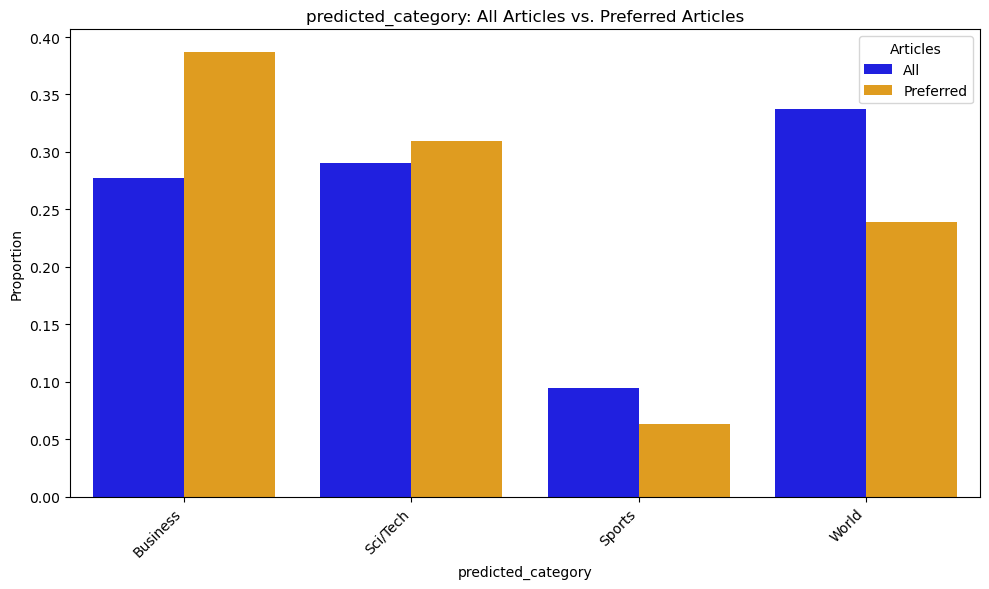

In [19]:
compare_variable('predicted_category')

/Users/jakepappo/micromamba/envs/sauron/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jakepappo/micromamba/envs/sauron/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


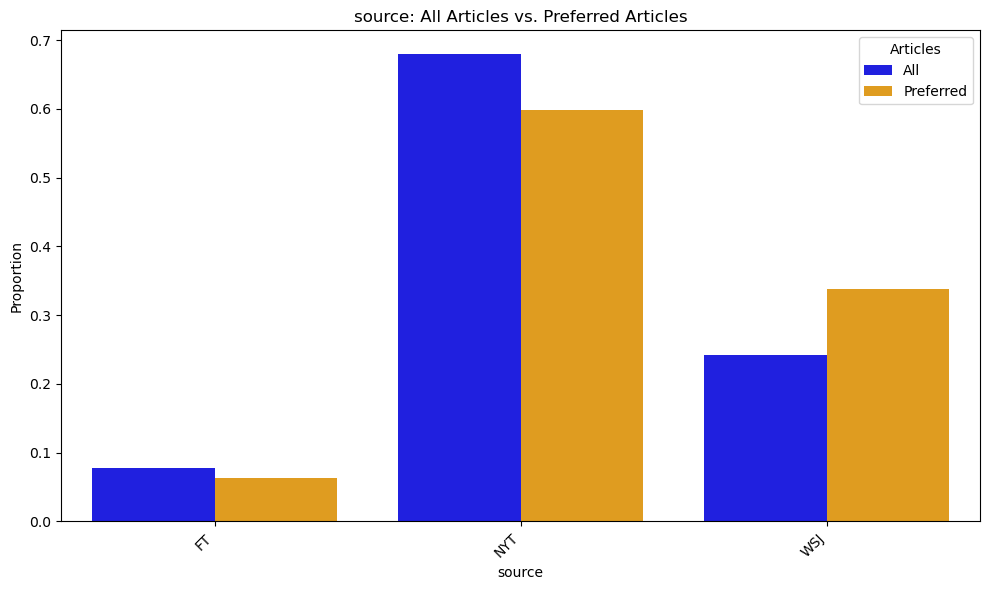

In [20]:
compare_variable('source')

### Recommender System

In [42]:
articles_df = pd.read_csv('archive/articles_all_09_05_24.csv')

#### Data Processing

In [44]:
articles_df['text'] = articles_df['title'].fillna('') + '. ' + articles_df['description'].fillna('')

In [45]:
X = articles_df[['text', 'feed_name', 'source', 'predicted_category']]
y = articles_df['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
# Define the preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['predicted_category', 'source', 'feed_name']),
    ]
)

# Fit the preprocessor on the training data
X_train = preprocessor.fit_transform(X_train_raw)

# Transform the test data
X_test = preprocessor.transform(X_test_raw)

#### Logistic Regression (baseline)

In [47]:
# Train a RandomForest model
logistic = LogisticRegressionCV(Cs=10, penalty='l2', scoring='f1', class_weight='balanced', n_jobs=-1, random_state=0)
logistic.fit(X_train, y_train);

In [48]:
y_pred_lr = logistic.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       125
           1       0.52      0.57      0.55        47

    accuracy                           0.74       172
   macro avg       0.68      0.69      0.68       172
weighted avg       0.75      0.74      0.74       172



In [49]:
f1_lr = f1_score(y_test, y_pred_lr)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr}")
print(f"F1 Score: {f1_lr}")

Accuracy: 0.7383720930232558
F1 Score: 0.5454545454545454


#### Random Forest

In [50]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'n_estimators': [200]
}

# Train a RandomForest model
rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train);

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [51]:
# Use the best model to predict on the test set
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       125
           1       0.52      0.47      0.49        47

    accuracy                           0.74       172
   macro avg       0.67      0.65      0.66       172
weighted avg       0.73      0.74      0.73       172



In [52]:
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf}")
print(f"F1 Score: {f1_rf}")

Accuracy: 0.7383720930232558
F1 Score: 0.4943820224719101


### Make Recommendations

In [53]:
def recommend_articles(model, X_test, articles_df, n_articles=15, min_per_category=2, random_sample=5):
    # Run inference to get predicted probabilities and categories
    y_pred_labels = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Add the predicted category and max probability to X_test DataFrame
    _, articles_test_df = train_test_split(articles_df, test_size=0.2, random_state=0)
    articles_test_df['predicted_label'] = y_pred_labels
    articles_test_df['preference_prob'] = y_pred_probs

    # Select the top 10 articles based on the highest predicted probabilities
    top_articles = articles_test_df.sort_values('preference_prob', ascending=False).head(10)

    # Ensure each category has at least `min_per_category` articles
    category_counts = top_articles['predicted_category'].value_counts()

    # Check for underrepresented categories
    for category in articles_test_df['predicted_category'].unique():
        while category_counts.get(category, 0) < min_per_category:
            # Find overrepresented categories
            overrepresented_categories = category_counts[category_counts > min_per_category].index.tolist()

            if not overrepresented_categories:
                # If no overrepresented categories remain, break out of the loop
                break

            # For each overrepresented category, remove the article with the lowest prob
            for over_category in overrepresented_categories:
                lowest_prob_article = top_articles[top_articles['predicted_category'] == over_category].tail(1)
                top_articles = top_articles.drop(lowest_prob_article.index)

                # Add the highest prob article from the underrepresented category
                highest_prob_missing_article = articles_test_df[
                    (articles_test_df['predicted_category'] == category) & 
                    (~articles_test_df.index.isin(top_articles.index))
                ].sort_values('preference_prob', ascending=False).head(1)
                
                if not highest_prob_missing_article.empty:
                    top_articles = pd.concat([top_articles, highest_prob_missing_article])

                # Update the counts after the change
                category_counts = top_articles['predicted_category'].value_counts()

                # If min_per_category is now satisfied for this category, stop
                if category_counts.get(category, 0) >= min_per_category:
                    break

    # Fill the remaining slots with random articles from the remaining pool
    remaining_pool = articles_test_df.drop(top_articles.index)
    random_articles = remaining_pool.sample(n=random_sample, random_state=109)

    # Combine top selected articles and randomly sampled articles
    final_selected_articles = pd.concat([top_articles, random_articles])

    return final_selected_articles

In [54]:
recommended_articles = recommend_articles(logistic, X_test, articles_df, n_articles=15, min_per_category=2, random_sample=5)

In [55]:
recommended_articles.sort_values(by='preference_prob', ascending=False)[['title', 'description', 'link', 'source', 'predicted_category', 'preference_prob', 'label']]

,title,description,link,source,predicted_category,preference_prob,label
689,OpenAI Eyes $100 Billion Valuation,"While some young A.I. companies have struggled to compete with the tech industry’s giants, OpenAI has been rapidly expanding.",https://www.nytimes.com/2024/08/28/technology/openai-valuation-funding-deal.html,NYT,Sci/Tech,0.916176,1
483,What Selloff? Stocks End August Higher After Head-Spinning Swings,"U.S. stock indexes closed a tumultuous August with gains, riding a string of encouraging economic data to overcome concerns about the labor market.",https://www.wsj.com/articles/global-stocks-markets-dow-news-08-30-2024-67081049?mod=rss_markets_main,WSJ,Business,0.912971,1
475,Stock Futures Are Little Changed as Investors Await Jobs Report Later This Week,U.S. stock and bond markets were closed for Labor Day. Germany’s DAX index closed at a record high.,https://www.wsj.com/articles/global-stocks-markets-dow-news-09-02-2024-034762d1?mod=rss_markets_main,WSJ,Business,0.898216,1
497,Nvidia's Future Relies on Chips That Push Technology's Limits,"As the company pushes the chip-making envelope, manufacturing hurdles are causing delays and higher costs.",https://www.wsj.com/articles/nvidias-future-relies-on-chips-that-push-technologys-limits-bd3839fc?mod=rss_Technology,WSJ,Sci/Tech,0.886830,1
691,Google Sued by Yelp in Antitrust Case,"Yelp complained for more than a decade that Google tilted the search market in its favor. After its rival’s landmark legal loss, it finally decided to sue.",https://www.nytimes.com/2024/08/28/technology/google-yelp-lawsuit.html,NYT,Sci/Tech,0.882615,1
682,"With X Blocked, Brazilians Turn to Other Social Media Platforms","The platform went dark across Brazil on Saturday, sending online commentators to new digital town squares.",https://www.nytimes.com/2024/08/31/technology/x-blocked-brazil-reactions.html,NYT,Sci/Tech,0.864215,1
650,Why Interest Rate Cuts Won’t Fix a Global Housing Affordability Crisis,"Central bankers are lowering borrowing costs, but that won’t be a cure-all for a widespread lack of affordable housing.",https://www.nytimes.com/2024/08/30/business/economy/interest-rate-cuts-housing-affordability-crisis.html,NYT,Business,0.805749,1
62,How Patrick Mahomes and Andy Reid Partnered Up to Reimagine Football,The Kansas City quarterback-coach duo is already among the most successful in N.F.L. history: “Let’s see how far we can take it.”,https://www.nytimes.com/athletic/5728141/2024/08/30/patrick-mahomes-andy-reid-2024-kc-chiefs/,NYT,Sports,0.710349,0
350,Haley’s Voters Size Up a Scrambled Presidential Race,"The people who voted against Donald Trump and for Nikki Haley in the G.O.P. primaries are weighing whether to support Kamala Harris. Either way, they could help sway a close election in swing states.",https://www.nytimes.com/2024/09/02/us/politics/harris-trump-nikki-haley-voters.html,NYT,World,0.694793,0
5,Presidential Awareness Month,Why are Democrats reviving the discredited claim that Joe Biden is as sharp as a tack?,https://www.wsj.com/articles/presidential-awareness-month-e08f3b7d,WSJ,World,0.617035,0
